In [1]:
import sys
sys.path = ['', 
#'C:\\Users\\regine.tsui\\.conda\\envs\\gen\\python38.zip', 
'C:\\Users\\regine.tsui\\.conda\\envs\\blast\\DLLs', 
'C:\\Users\\regine.tsui\\.conda\\envs\\blast\\lib', 
'C:\\Users\\regine.tsui\\.conda\\envs\\blast', 
'C:\\Users\\regine.tsui\\.conda\\envs\\blast\\lib\\site-packages',
'C:\\Users\\regine.tsui\\.conda\\envs\\blast\\Library\\bin']

#'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 
#'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
#'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 
#'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin']

In [2]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
#from skimage import img_as_bool, img_as_int, img_as_float64
from skimage import img_as_float64, measure
from skimage.io import imread
import matplotlib.pyplot as plt
import pickle
import ezdxf

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *

In [14]:
class Points(object):
    def __init__(self, xyz, data):
        self.xyz = xyz
        self.data = data

    def export_MIC_grid(self, filepath, gridsize):
        export_grid(
            filepath, self.MIC, self.xyz, self.MIC_grid_settings, gridsize)
        
class Terrain(object):
    def __init__(self, elev, origin, resolution):
        self.elev = elev
        self.origin = origin
        self.resolution = resolution
        self.to_points()
    
    
    def to_points(self):
        idx = np.mgrid[:self.elev.shape[0],:self.elev.shape[1]]
        x = idx[0].ravel()
        y = idx[1].ravel()
        z = self.elev.ravel()
        trans_x_y = from_grid(
            np.vstack([x, y]).T, self.origin, self.resolution)
        self.xyz = np.vstack([trans_x_y[:,0], trans_x_y[:,1], z]).T
    
    def export_AOPContours(self, filepath):
        prediction = self.maxAOP.reshape(self.elev.shape)
        export_contours(
            filepath, prediction, layer_suffix='AOP ', 
            contour_settings=self.AOP_contour_settings, 
            origin=self.origin, resolution=self.resolution)
    
    
    def export_PPVContours(self, filepath):
        prediction = self.maxPPV.reshape(self.elev.shape)
        export_contours(
            filepath, prediction, layer_suffix='PPV ', 
            contour_settings=self.PPV_contour_settings,
            origin=self.origin, resolution=self.resolution)

        
class BlastModel(object):
    
    def __init__(self, PPV_K, PPV_B, AOP_K, AOP_B, AOP_AR):
        self.PPV_K = PPV_K
        self.PPV_B = PPV_B
        self.AOP_K = AOP_K
        self.AOP_B = AOP_B
        self.AOP_AR = AOP_AR

        
    def loadBlastPoints(self, filepath, sheet_name):
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        xyz = df.iloc[:,1:4].values
        self.BlastPoints = Points(xyz, data=df)
        
        
    def loadPPVSenstiveReceivers(self, filepath, sheet_name):
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        xyz = df.iloc[:,2:5].values
        PPV_limit = df.iloc[:,5].values
        self.PPV_SR = Points(xyz, data=df)
        self.PPV_SR.limit = PPV_limit

        
    def loadAOPSenstiveReceivers(self, filepath, sheet_name):
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        xyz = df.iloc[:,1:4].values
        AOP_limit = df.iloc[:,4].values
        self.AOP_SR = Points(xyz, data=df)
        self.AOP_SR.limit = AOP_limit
        
        
    def loadSenstiveReceivers(self, filepath, sheet_name):
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        xyz = df.iloc[:,2:5].values
        self.SR = Points(xyz, data=df)

        
    def loadTerrain(self, filepath, origin, resolution):
        elev = img_as_float64(imread(filepath))
        self.Terrain = Terrain(elev, origin, resolution)
        
        
    def loadDXFSettings(self, filepath):
        self.BlastPoints.MIC_grid_settings = pd.read_excel(
            filepath, sheet_name='MIC_color_table')
        self.Terrain.PPV_contour_settings = pd.read_excel(
            filepath, sheet_name='PPV_Contours')
        self.Terrain.AOP_contour_settings = pd.read_excel(
            filepath, sheet_name='AOP_Contours')

        
    def optimize_MIC(self):
        BP, SR1, SR2 = self.BlastPoints.xyz, self.PPV_SR.xyz, self.AOP_SR.xyz
        cPPV, cAOP = self.PPV_SR.limit, self.AOP_SR.limit
        
        # Calculate distances
        R_SR1 = spatial.distance.cdist(BP, SR1)
        R_SR2 = spatial.distance.cdist(BP, SR2)
        
        # Calculate W for each blast point for each sensitive receiver
        W_PPV = cal_W_from_PPV_R(R_SR1, cPPV, K=self.PPV_K, B=self.PPV_B)
        W_AOP = cal_W_from_AOP_R(R_SR2, cAOP, K=self.AOP_K, B=self.AOP_B, AR=self.AOP_AR)
        
        # Max allowable W (i.e. min calculated W) for each blast point for each type
        min_W_PPV = np.min(W_PPV, axis=1)
        min_W_AOP = np.min(W_AOP, axis=1)
        
        # Index of min W for each blast point 
        # (for identifying controlling sensitive receiver)
        min_idx_PPV = np.argmin(W_PPV, axis=1)
        min_idx_AOP = np.argmin(W_AOP, axis=1)

        # Compare AOP & PPV to find min W  
        min_W_AOP_PPV = np.vstack([min_W_PPV, min_W_AOP])
        min_W = np.min(min_W_AOP_PPV, axis=0)
        AOP_limited = np.argmin(min_W_AOP_PPV, axis=0)

        self.BlastPoints.unrestricted_MIC = min_W
        self.BlastPoints.AOP_limited = AOP_limited.astype('bool')
        self.BlastPoints.min_idx_PPV = min_idx_PPV
        self.BlastPoints.min_idx_AOP = min_idx_AOP
        
        return self.BlastPoints
    
    
    def restrict_MIC(self, T):
        self.T = T
        MIC = self.BlastPoints.unrestricted_MIC.copy()
        MIC[MIC >= T] = T
        self.BlastPoints.MIC = MIC.astype('float32')
        return self.BlastPoints.MIC
    
    
    def generate_BPsummary(self, filepath):
        
        df = self.BlastPoints.data.copy()
        df['Optimized MIC'] = self.BlastPoints.MIC
        df['Optimized MIC (Unrestricted)'] = self.BlastPoints.unrestricted_MIC
        
        idx_PPV = self.BlastPoints.min_idx_PPV
        idx_AOP = self.BlastPoints.min_idx_AOP
        AOP_limited = self.BlastPoints.AOP_limited
        ControlSR_PPV = self.PPV_SR.data.iloc[idx_PPV]['Feature Description'].values
        ControlSR_AOP = self.AOP_SR.data.iloc[idx_AOP]['AOP Point'].values
        
        df['Controlling SR'] = np.where(AOP_limited, ControlSR_AOP, ControlSR_PPV)
        df['AOP_limited'] = AOP_limited
        df['Controlling SR (PPV)'] = ControlSR_PPV
        df['Controlling SR (AOP)'] = ControlSR_AOP

        df.to_excel(filepath)
        
        return df
        
    def predict_SR(self):
        self.SR.max_PPV, self.SR.max_AOP = self.predict(
            self.SR.xyz, chunksize=1000)
        
        
    def generate_SRsummary(self, filepath):
        
        df = self.SR.data.copy()
        df['MaxPPV'] = self.SR.max_PPV
        df['MaxAOP'] = self.SR.max_AOP
        
        outdf = df.groupby('Feature Description')[['MaxAOP', 'MaxPPV']].max()
        outdf['Allowable PPV (mm/s)'] = df.groupby('Feature Description')[['Allowable PPV\n(mm/s)']].first()
        
        outdf.to_excel(filepath)
        
        return outdf
    
    def predict_terrain(self, PPV_to_ignore=None, AOP_to_ignore=None):

        # Calculate buffer extent (R_buffer) based on Max charge (T)
        # and PPV / AOP levels to ignore in predictions
        # to reduce computations
        R_cPPV = cal_R_from_W_PPV(
            PPV_to_ignore, W=self.T, K=self.PPV_K, B=self.PPV_B)
        R_cAOP = cal_R_from_W_AOP(
            AOP_to_ignore, W=self.T, K=self.AOP_K, B=self.AOP_B, AR=self.AOP_AR)
        R_buffer = np.max([R_cPPV, R_cAOP])
        self.Terrain.R_buffer = R_buffer
        
        # Build kdtree based on blast points
        # nndist: distance to nearest neighbour (blast point)
        # for each terrain point
        kdtree = spatial.KDTree(self.BlastPoints.xyz[:,:2])
        nndist, _ = kdtree.query(self.Terrain.xyz[:,:2], k=1)
        
        # Caluclate buffered points only
        buffered = nndist < R_buffer
        max_PPV, max_AOP = self.predict(
            self.Terrain.xyz[buffered], chunksize=1000)
        
        # Push buffered points back to full elevation arrays
        max_PPV_full = np.zeros(self.Terrain.xyz.shape[0])
        max_AOP_full = np.zeros(self.Terrain.xyz.shape[0])
        max_PPV_full[buffered] = max_PPV
        max_AOP_full[buffered] = max_AOP
        
        self.Terrain.maxPPV, self.Terrain.maxAOP = max_PPV_full, max_AOP_full
            
    
    def predict(self, points, chunksize):

        point_no = points.shape[0]
        chunknum = point_no//chunksize
        remain = 0 if point_no%chunksize==0 else 1
        
        max_PPV = np.zeros(point_no)
        max_AOP = np.zeros(point_no)
        
        MIC = self.BlastPoints.MIC
        BP = self.BlastPoints.xyz
        
        for n in range (chunknum+remain):
            if (n+1)*chunksize > point_no:
                start, end = n*chunksize, point_no
            else:
                start, end = n*chunksize, (n+1)*chunksize
            
            _R = spatial.distance.cdist(BP, points[start:end,:]).astype('float32')
            
            _PPV = cal_PPV_from_W_R(_R, MIC, K=self.PPV_K, B=self.PPV_B)
            _AOP = cal_AOP_from_W_R(_R, MIC, K=self.AOP_K, B=self.AOP_B, AR=self.AOP_AR)
            
            max_PPV[start:end] = np.max(_PPV, axis=0)
            max_AOP[start:end] = np.max(_AOP, axis=0)
        
        return max_PPV, max_AOP
    
    
    def save_state(self, filepath):
        with open(filepath, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)
    

def export_contours(
    filepath, prediction, layer_suffix, contour_settings, origin, resolution):
    
    # hatch requires the DXF R2000 (AC1015) format or later
    dwg = ezdxf.new('AC1018')  
    # adding entities to the model space
    msp = dwg.modelspace()  
    
    contourLevels = contour_settings.iloc[:,0]
    
    layerColors = contour_settings.apply(
        lambda x: (x['R'], x['G'], x['B']), axis=1)
    
    for i, level in enumerate(contourLevels):
        
        layerName = layer_suffix + str(level)
        layerColor = ezdxf.rgb2int(layerColors[i])
        
        dwg.layers.new(name=layerName, 
                       dxfattribs={'true_color': layerColor})
        
        contours = measure.find_contours(prediction, level)
        
        for contour in contours:
            contour = from_grid(contour, origin, resolution)
            line = msp.add_polyline2d(
                contour, dxfattribs={'layer': layerName})
            
    dwg.saveas(filepath)
    
    
def export_grid(filepath, MIC, xyz, grid_settings, gridsize):
    
    # hatch requires the DXF R2000 (AC1015) format or later
    dwg = ezdxf.new('AC1018')
    # adding entities to the model space
    msp = dwg.modelspace()  
    
    interval_no = grid_settings.shape[0]
    
    layerNames = "MIC " + grid_settings['From'].astype(str) + " to lte " + \
                 grid_settings['To'].astype(str) + " kg delay"
    
    layerColors = grid_settings.apply(lambda x: (x['R'], x['G'], x['B']), axis=1)
    
    BP_idx = np.arange(MIC.shape[0])
    
    paths = get_grid_boundary(xyz, gridsize)
    
    for i in range(interval_no):
        
        layerName = layerNames[i]
        layerColor = ezdxf.rgb2int(layerColors[i])
        
        dwg.layers.new(name=layerName)
        
        start, end = grid_settings['From'].iloc[i], grid_settings['To'].iloc[i]
        selected_BP_idx = BP_idx[(MIC >= start) & (MIC < end)]
        
        for idx in selected_BP_idx:
            hatch = msp.add_hatch(dxfattribs={'layer': layerName})
            hatch.set_dxf_attrib('true_color', layerColor)
            
            # edit boundary path (context manager)
            with hatch.edit_boundary() as boundary:   
                boundary.add_polyline_path(paths[idx], is_closed=1)    
            
    dwg.saveas(filepath)
    
    
def get_grid_boundary(xyz, gridsize):

    x1 = xyz[:,0] - gridsize/2
    x2 = xyz[:,0] + gridsize/2
    y1 = xyz[:,1] - gridsize/2
    y2 = xyz[:,1] + gridsize/2
    
    paths = []
    for i in range(xyz.shape[0]):
        paths.append([(x1[i], y1[i]), (x1[i], y2[i]), 
                      (x2[i], y2[i]), (x2[i], y1[i])])
    
    return paths

In [5]:
%%time
proj_Dir = r'INPUT\NENT\Opti_20220503174605'

model = BlastModel(PPV_K=644, PPV_B=1.22, AOP_K=3.17, AOP_B=1.2, AOP_AR=5)
model.loadBlastPoints(os.path.join(proj_Dir, "BP_All.xlsx"), sheet_name='BP')
model.loadPPVSenstiveReceivers(os.path.join(proj_Dir, "SR.xlsx"), sheet_name='Opti')
model.loadAOPSenstiveReceivers(os.path.join(proj_Dir, "AOP.xlsx"), sheet_name='AOP')

Wall time: 2.73 s


In [6]:
%%time
model.optimize_MIC()
model.restrict_MIC(T=10)

Wall time: 4.9 s


array([0.49664938, 0.01575865, 0.01575515, ..., 0.05389725, 0.04368558,
       0.03736417], dtype=float32)

In [7]:
%%time
model.generate_BPsummary('BP.xlsx')
model.loadSenstiveReceivers(os.path.join(proj_Dir, "SR.xlsx"), sheet_name='Opti')
model.predict_SR()
model.generate_SRsummary('SR.xlsx');

Wall time: 11.4 s


,MaxAOP,MaxPPV,Allowable PPV (mm/s)
Feature Description,,,
132kV Overhead Cable,109.162125,3.000995,13
3NW-B/C 68,120.351250,11.017437,25
3NW-B/C 69,110.287621,3.425505,25
3NW-B/C 70,108.054794,2.645298,25
3NW-B/C 77,105.642258,1.994518,25
3NW-D/C 247,119.511093,10.077310,25
3NW-D/C 248,131.664459,13.768184,25
3NW-D/C 249,134.035294,23.223047,25
3NW-D/C 252,128.508301,13.914684,25


In [ ]:
with open('model2.pkl', 'rb') as inp:
    model_load2 = pickle.load(inp)

In [ ]:
model.save_state('model2.pkl')

In [7]:
model.loadTerrain(os.path.join(proj_Dir, "merged_10m.tif"), 
                  origin=np.array([834000, 846000]), 
                  resolution=np.array([10, -10]))

In [8]:
%%time
model.predict_terrain(PPV_to_ignore=4.5, AOP_to_ignore=130)

Wall time: 12.5 s


In [9]:
terrain = model.Terrain

In [10]:
model.loadDXFSettings(os.path.join(proj_Dir, "Settings.xlsx"))

In [11]:
terrain.export_AOPContours('AOP_contours.dxf')
terrain.export_PPVContours('PPV_contours.dxf')

In [15]:
blastP = model.BlastPoints
blastP.export_MIC_grid('MIC_grid.dxf', gridsize=5)

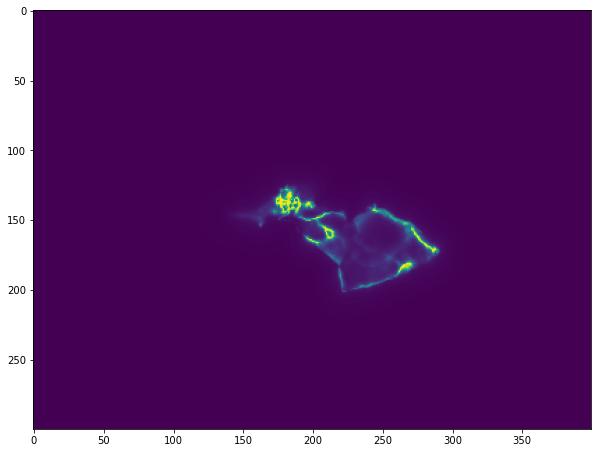

In [58]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(terrain.maxPPV.reshape(terrain.elev.shape))
ax1.set_aspect(1)

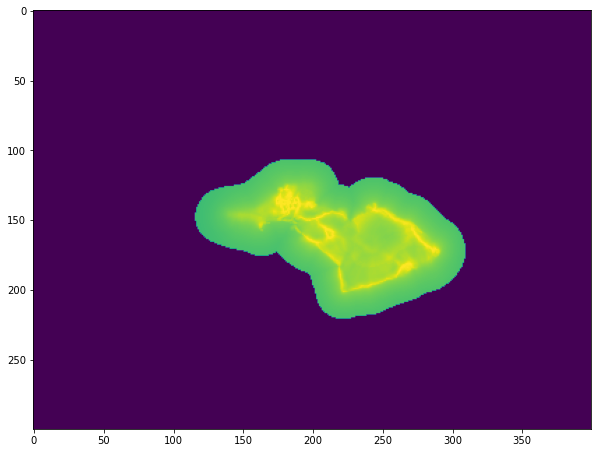

In [59]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(terrain.maxAOP.reshape(terrain.elev.shape))
ax1.set_aspect(1)

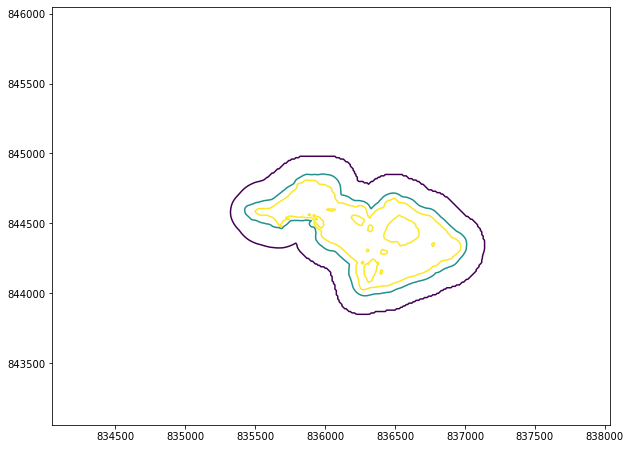

In [62]:
x_1 = terrain.xyz[:,0].reshape(terrain.elev.shape)
y_1 = terrain.xyz[:,1].reshape(terrain.elev.shape)

fig, ax1 = plt.subplots(figsize=(10,10))
contours = ax1.contour(x_1, y_1, terrain.maxAOP.reshape(terrain.elev.shape), [110, 120, 130])
ax1.set_aspect(1)

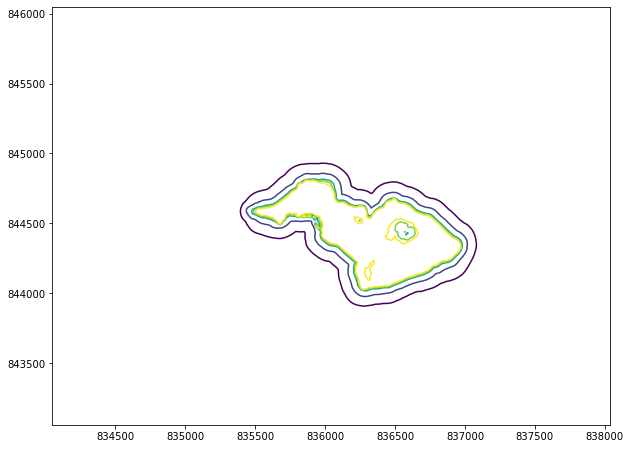

In [69]:
x_1 = terrain.xyz[:,0].reshape(terrain.elev.shape)
y_1 = terrain.xyz[:,1].reshape(terrain.elev.shape)

fig, ax1 = plt.subplots(figsize=(10,10))
contours = ax1.contour(x_1, y_1, terrain.maxPPV.reshape(terrain.elev.shape), [5, 10, 20, 25, 30])
ax1.set_aspect(1)

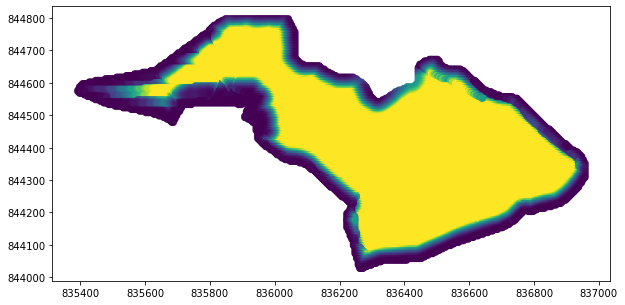

In [75]:
bp = model.BlastPoints
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(bp.xyz[:,0], bp.xyz[:,1], c=bp.MIC)
ax1.set_aspect(1)

In [139]:
%%time
gridsize = 5
x1 = bp.xyz[:,0] - gridsize/2
x2 = bp.xyz[:,0] + gridsize/2
y1 = bp.xyz[:,1] - gridsize/2
y2 = bp.xyz[:,1] + gridsize/2

paths = []
for i in range(bp.xyz.shape[0]):
    paths.append([(x1[i], y1[i]), (x1[i], y2[i]), 
                  (x2[i], y2[i]), (x2[i], y1[i])])

Wall time: 33 ms


In [ ]:
def get_grid_boundary(xyz, gridsize):

    x1 = xyz[:,0] - gridsize/2
    x2 = xyz[:,0] + gridsize/2
    y1 = xyz[:,1] - gridsize/2
    y2 = xyz[:,1] + gridsize/2
    
    paths = []
    for i in range(bp.xyz.shape[0]):
        paths.append([(x1[i], y1[i]), (x1[i], y2[i]), 
                      (x2[i], y2[i]), (x2[i], y1[i])])
    
    return paths

In [ ]:
    def export_MIC_grid(self, filepath):
        export_grid(
            filepath, self.MIC, self.xyz, 
            grid_settings=self.MIC_grid_settings, gridsize)

def export_grid(filepath, MIC, xyz, grid_settings, gridsize):
    
    # hatch requires the DXF R2000 (AC1015) format or later
    dwg = ezdxf.new('AC1018')
    # adding entities to the model space
    msp = dwg.modelspace()  
    
    interval_no = grid_settings.shape[0]
    
    layerNames = "MIC " + grid_settings['From'].astype(str) + " to lte " + \
                 grid_settings['To'].astype(str) + " kg delay"
    
    layerColors = grid_settings.apply(lambda x: (x['R'], x['G'], x['B']), axis=1)
    
    BP_idx = np.arange(MIC.shape[0])
    
    paths = get_grid_boundary(xyz, gridsize)
    
    for i in range(interval_no):
        
        layerName = layerNames[i]
        layerColor = ezdxf.rgb2int(layerColors[i])
        
        dwg.layers.new(name=layerName)
        
        start, end = grid_settings['From'].iloc[i], grid_settings['To'].iloc[i]
        selected_BP_idx = BP_idx[(MIC >= start) & (MIC < end)]
        
        for idx in selected_BP_idx:
            hatch = msp.add_hatch(dxfattribs={'layer': layerName})
            hatch.set_dxf_attrib('true_color', layerColor)
            
            # edit boundary path (context manager)
            with hatch.edit_boundary() as boundary:   
                boundary.add_polyline_path(paths[idx], is_closed=1)    
            
    dwg.saveas(filepath)

In [188]:
%%time

    dwg = ezdxf.new('AC1018')  # hatch requires the DXF R2000 (AC1015) format or later
    msp = dwg.modelspace()  # adding entities to the model space

    MIC_color = pd.read_excel(
        os.path.join(proj_Dir, 'Settings.xlsx'), sheet_name='MIC_color_table')
    interval_no = MIC_color.shape[0]

    layerNames = "MIC " + MIC_color['From'].astype(str) + " to lte " + MIC_color['To'].astype(str) + " kg delay"
    layerColors = MIC_color.apply(lambda x: (x['R'], x['G'], x['B']), axis=1)

    BP_idx = np.arange(bp.MIC.shape[0])

    for i in range(interval_no):

        layerName = layerNames[i]
        layerColor = ezdxf.rgb2int(layerColors[i])

        dwg.layers.new(name=layerName)

        start, end = MIC_color['From'].iloc[i], MIC_color['To'].iloc[i]
        selected_BP_idx = BP_idx[(bp.MIC >= start) & (bp.MIC < end)]

        for idx in selected_BP_idx:
            hatch = msp.add_hatch(dxfattribs={'layer': layerName})
            hatch.set_dxf_attrib('true_color', layerColor)

            with hatch.edit_boundary() as boundary:   # edit boundary path (context manager)
                boundary.add_polyline_path(paths[idx], is_closed=1)    

    dwg.saveas('test.dxf')

Wall time: 3.23 s


In [187]:
dwg = ezdxf.new('AC1018')  # hatch requires the DXF R2000 (AC1015) format or later
msp = dwg.modelspace()  # adding entities to the model space
PPV_contour_settings = pd.read_excel(
    os.path.join(proj_Dir, 'Settings.xlsx'), sheet_name='PPV_Contours')

PPV_contour_levels = PPV_contour_settings.iloc[:,0]
layerColors = PPV_contour_settings.apply(lambda x: (x['R'], x['G'], x['B']), axis=1)

for i, PPV in enumerate(PPV_contour_levels):
    
    layerName = 'PPV ' + str(PPV)
    layerColor = ezdxf.rgb2int(layerColors[i])
    
    dwg.layers.new(name=layerName, dxfattribs={'true_color': layerColor})
    
    contours = measure.find_contours(terrain.maxPPV.reshape(terrain.elev.shape), PPV)
    
    for contour in contours:
        contour = from_grid(contour, terrain.origin, terrain.resolution)
        line = msp.add_polyline2d(contour, dxfattribs={'layer': layerName})
        
dwg.saveas('test2.dxf')

In [189]:
dwg = ezdxf.new('AC1018')  # hatch requires the DXF R2000 (AC1015) format or later
msp = dwg.modelspace()  # adding entities to the model space
AOP_contour_settings = pd.read_excel(
    os.path.join(proj_Dir, 'Settings.xlsx'), sheet_name='AOP_Contours')

AOP_contour_levels = AOP_contour_settings.iloc[:,0]
layerColors = AOP_contour_settings.apply(lambda x: (x['R'], x['G'], x['B']), axis=1)

for i, AOP in enumerate(AOP_contour_levels):
    
    layerName = 'AOP ' + str(AOP)
    layerColor = ezdxf.rgb2int(layerColors[i])
    
    dwg.layers.new(name=layerName, dxfattribs={'true_color': layerColor})
    
    contours = measure.find_contours(terrain.maxAOP.reshape(terrain.elev.shape), AOP)
    
    for contour in contours:
        contour = from_grid(contour, terrain.origin, terrain.resolution)
        line = msp.add_polyline2d(contour, dxfattribs={'layer': layerName})
        
dwg.saveas('test3.dxf')

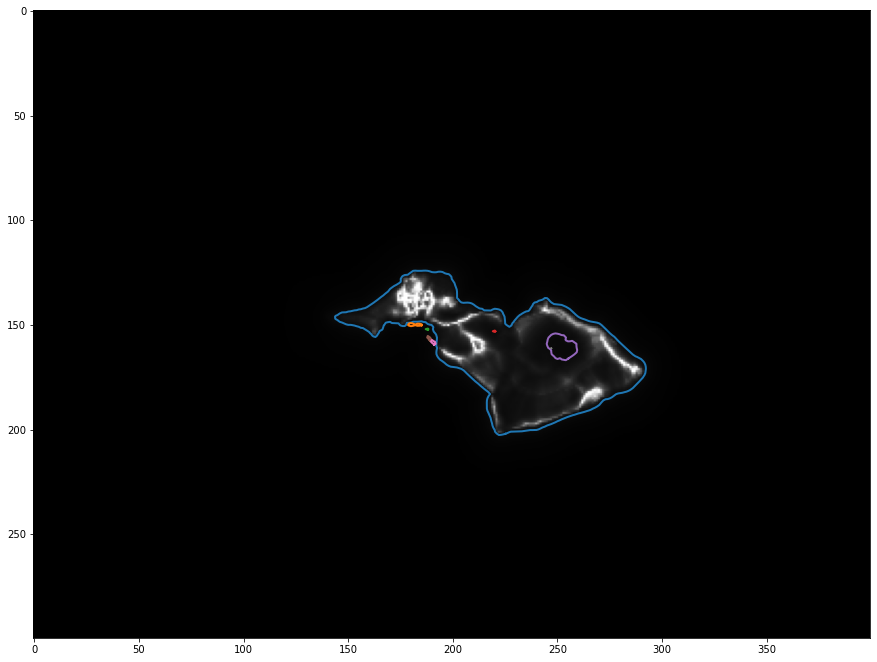

In [16]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(terrain.maxPPV.reshape(terrain.elev.shape), cmap=plt.cm.gray)
contours = measure.find_contours(terrain.maxPPV.reshape(terrain.elev.shape), 25)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)